### Import

In [1]:
!pip install pandas transformers torch matplotlib

  Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.6.2-cp38-abi3-win_amd64.whl.metadata (4.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.0 MB 2.6 MB/s eta 0:00:05
   ----- ---------------------------------- 1.6/12.0 MB 4.3 MB/s eta 0:00:03
   --------- ------------------------------ 2.9/12.0 MB 5.0 MB/s eta 0:00:02
   ------------- -------------------------- 4.2/12.0 MB 5.4 MB/s eta 0:00:02
   ------------------ --------------------- 5.5/12.0 MB 5.4 MB/s eta 0:00:02
   ---------------------- ----------------- 6.8/12.0 MB 5.6 MB/s eta 0:00:01
   --------------------------- ------------ 8.1/12.0 MB 5.7 MB/s eta 0:00:01
   ------------------------------- -------- 9.4/12.0 MB 5.7 MB/s eta 0:00:01
   ------------------------------

### Import file

In [3]:
import pandas as pd

# Replace with your CSV filename
file_path = "Data/all-data.csv"

df = pd.read_csv(file_path, header=None, names=["label", "text"], encoding="latin1")
df.head()

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


# BERT

In [4]:
from transformers import pipeline

bert_classifier = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)

c:\Users\Kanta\.conda\envs\pytorch_cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use cuda:0


In [5]:
bert_results = bert_classifier(df["text"].tolist())
df["bert_sentiment"] = [r["label"] for r in bert_results]
df["bert_score"] = [r["score"] for r in bert_results]
df.head()

,label,text,bert_sentiment,bert_score
0,neutral,"According to Gran , the company has no plans t...",3 stars,0.282291
1,neutral,Technopolis plans to develop in stages an area...,4 stars,0.212100
2,negative,The international electronic industry company ...,1 star,0.458850
3,positive,With the new production plant the company woul...,5 stars,0.475899
4,positive,According to the company 's updated strategy f...,4 stars,0.324346


In [10]:
def stars_to_sentiment(label):
    # label is like "3 stars" or "1 star"
    n = int(label.split()[0])
    if n <= 2:
        return "negative"
    elif n == 3:
        return "neutral"
    else:
        return "positive"

df["bert_sentiment_mapped"] = df["bert_sentiment"].apply(stars_to_sentiment)
df[["text", "bert_sentiment", "bert_sentiment_mapped", "finbert_sentiment"]].head()

,text,bert_sentiment,bert_sentiment_mapped,finbert_sentiment
0,"According to Gran , the company has no plans t...",3 stars,neutral,neutral
1,Technopolis plans to develop in stages an area...,4 stars,positive,neutral
2,The international electronic industry company ...,1 star,negative,negative
3,With the new production plant the company woul...,5 stars,positive,positive
4,According to the company 's updated strategy f...,4 stars,positive,positive


# FinBERT

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

finbert = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",
    tokenizer="ProsusAI/finbert"
)

finbert_results = finbert(df["text"].tolist())
df["finbert_sentiment"] = [r["label"] for r in finbert_results]
df["finbert_score"] = [r["score"] for r in finbert_results]
df.head()

Device set to use cuda:0


,label,text,bert_sentiment,bert_score,finbert_sentiment,finbert_score,bert_sentiment_mapped
0,neutral,"According to Gran , the company has no plans t...",3 stars,0.282291,neutral,0.885731,neutral
1,neutral,Technopolis plans to develop in stages an area...,4 stars,0.212100,neutral,0.533838,positive
2,negative,The international electronic industry company ...,1 star,0.458850,negative,0.972056,negative
3,positive,With the new production plant the company woul...,5 stars,0.475899,positive,0.947900,positive
4,positive,According to the company 's updated strategy f...,4 stars,0.324346,positive,0.859708,positive


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


### Visualization

In [15]:
import pandas as pd

sentiments = ["positive", "neutral", "negative"]

bert_counts = df["bert_sentiment_mapped"].value_counts().reindex(sentiments, fill_value=0)
finbert_counts = df["finbert_sentiment"].value_counts().reindex(sentiments, fill_value=0)

bert_counts, finbert_counts

(bert_sentiment_mapped
 positive    2282
 neutral      518
 negative    2046
 Name: count, dtype: int64,
 finbert_sentiment
 positive    1549
 neutral     2566
 negative     731
 Name: count, dtype: int64)

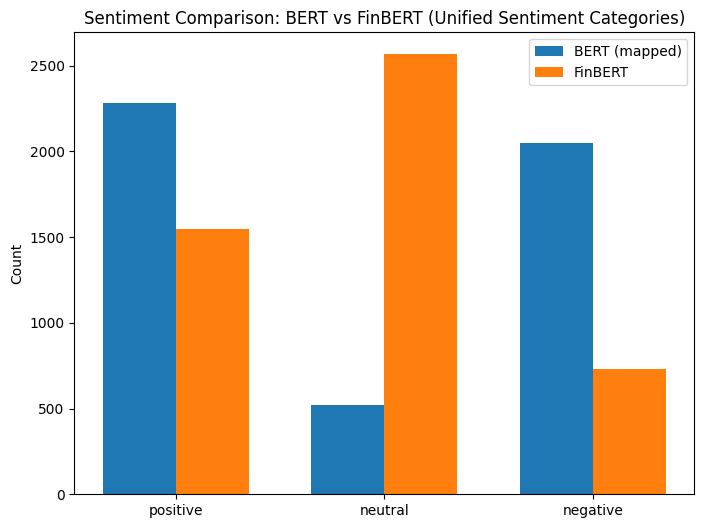

In [16]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(sentiments))  # positions
width = 0.35  # width of bars

plt.figure(figsize=(8,6))
plt.bar(x - width/2, bert_counts, width, label='BERT (mapped)')
plt.bar(x + width/2, finbert_counts, width, label='FinBERT')

plt.xticks(x, sentiments)
plt.ylabel("Count")
plt.title("Sentiment Comparison: BERT vs FinBERT (Unified Sentiment Categories)")
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import classification_report

print("BERT Mapped:")
print(classification_report(df["label"], df["bert_sentiment_mapped"]))

print("FinBERT:")
print(classification_report(df["label"], df["finbert_sentiment"]))

BERT Mapped:
              precision    recall  f1-score   support

    negative       0.25      0.85      0.39       604
     neutral       0.64      0.12      0.20      2879
    positive       0.29      0.48      0.36      1363

    accuracy                           0.31      4846
   macro avg       0.39      0.48      0.32      4846
weighted avg       0.50      0.31      0.27      4846

FinBERT:
              precision    recall  f1-score   support

    negative       0.80      0.97      0.88       604
     neutral       0.96      0.86      0.91      2879
    positive       0.81      0.92      0.86      1363

    accuracy                           0.89      4846
   macro avg       0.86      0.92      0.88      4846
weighted avg       0.90      0.89      0.89      4846

